### Abstract

Binary classification is a fundamental problem in data science and machine learning. The objective of this project was to build an MLOPs piepline for a model that predicts hotel reservation cancellations. 

Here I simulate and MLOPs workflow that supports the training and prediction pipeline, utilizing the tuned XGB model obtained from the data science offline experimentation. The MLOPs pipeline is comprised of three stages: preprocessing (Imputer and Encoder) with adjustable feature parameters for training and prediction, training and evaluation with configurable threshold logic and evaluation metrics, and prediction on the entire dataset using the latest promoted model.

Keywords: Binary Classification, XGBoost, Class Imbalance, MLOPs Pipeline.

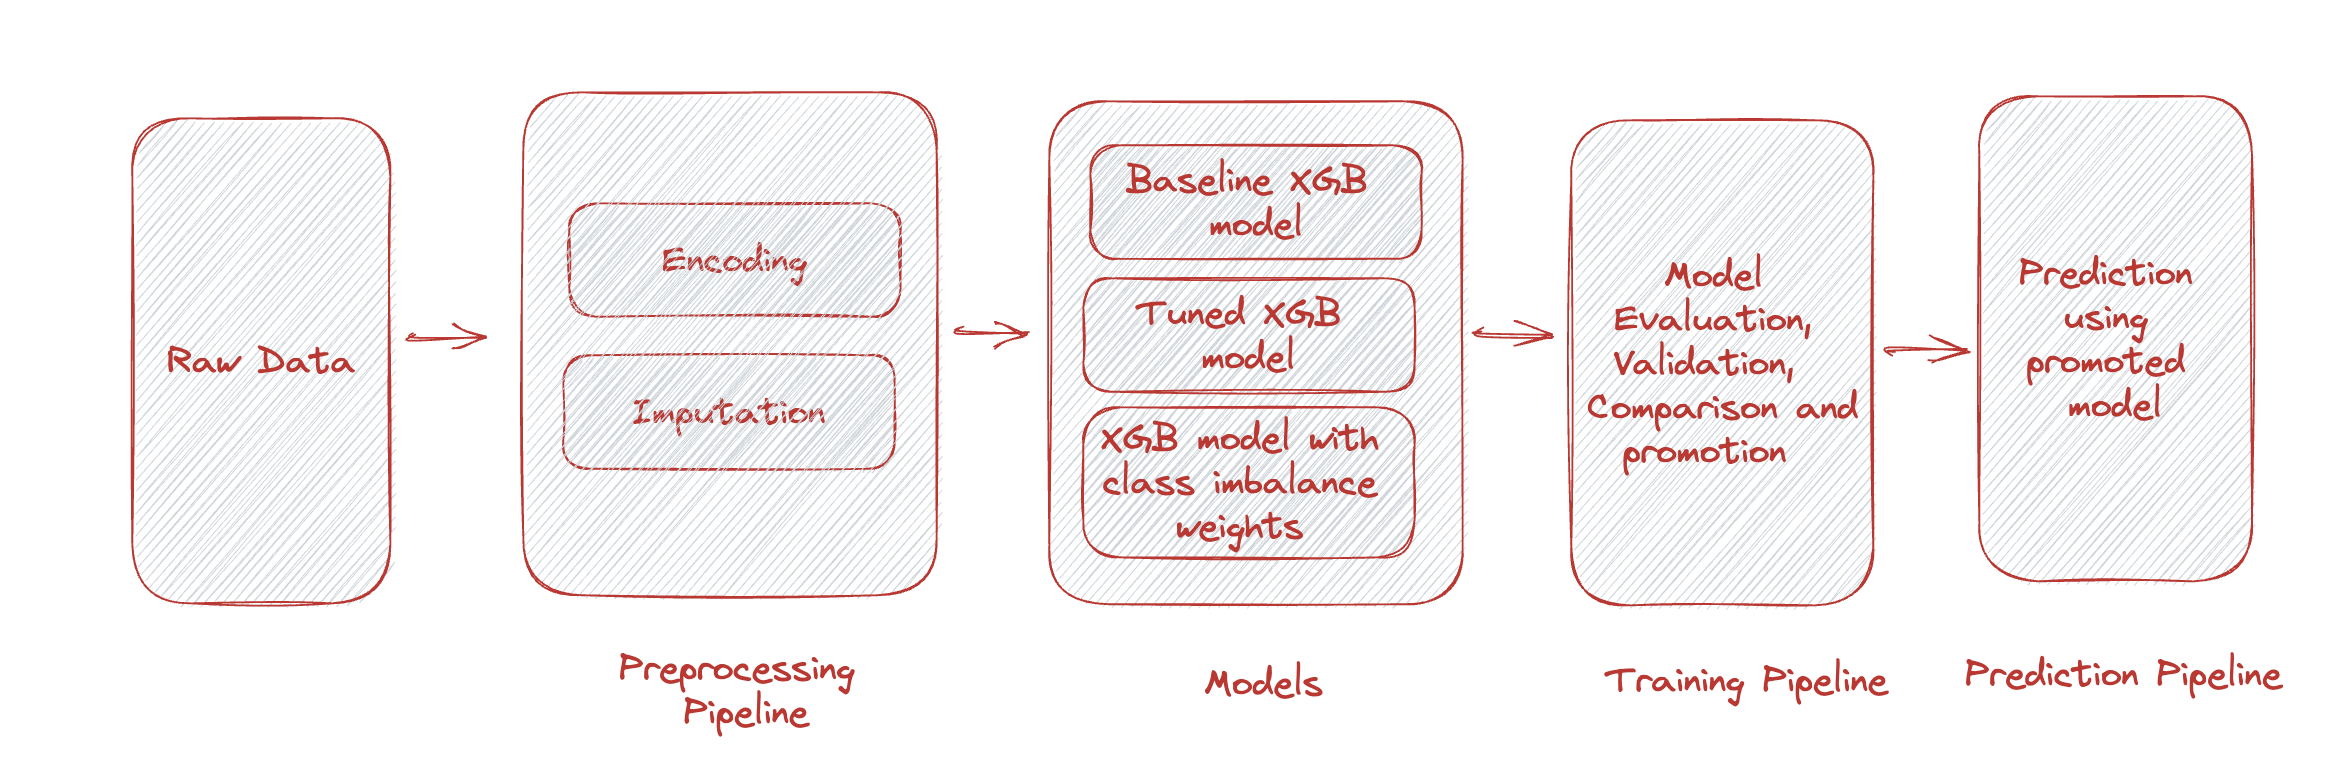

## Engineering

In a separate set of files (ie not in this Jupyter Notebook), take the model that you created and implement basic training and prediction pipelines that would simulate what you would implement in production. These pipelines should broadly cover the following steps:
* Preprocessing
  * This will be based off the raw data received at the beginning of DS assignment
* Model Training & Evaluation
* Predictions (in batch)

*Some Requirements*:
* The training and prediction pipelines should be independent of each other (though they can draw from the same base methods/classes if need be).
* The prediction job predicts on the latest "promoted" model.
* All model artifacts and outputs are stored according to date partition or, where relevant, by version
* The training job includes logic around "model promotion"
  * If there is an 10% increase in ROC/AUC over the previous model then promote model; else don't promote model
* For both jobs, a user (human or machine) should be able to simply call on the script or import a class to run the pipeline

*Bonus*:

Parameterize the pipelines according to how a Data Scientist would use this.
* Allow for arbitrary set of features to be passed into training (and prediction) job
* Parameterize the % threshold increase to promote a model
* Parameterize which evaluation metric can be used. To keep it simple, stick with most common metrics for evaluation


Organize the files in a folder structure that would emulate how you would organize the code in a Github repo. Zip up all files and send them back to the recruiter by the morning of your interview.

## Preprocessing Pipeline

### Preprocessing Module

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split


class HotelBookingPreprocessor:
    def __init__(
        self, data_path, cols_to_drop=["reservation_status", "reservation_status_date"]
    ):
        """
        A class to preprocess the hotel booking data.

        :param data_path: str, the path to the csv data file.
        :param cols_to_drop: list, the list of column names to drop from the dataset.
        """
        self.data_path = data_path
        self.cols_to_drop = cols_to_drop

    def _load_data(self, path):
        """
        Load the dataset from the given path.

        :param path: str, the path to the csv data file.
        """
        self.df = pd.read_csv(path)

    def _feature_engineer(self):
        # create a feature for total nights stayed
        self.df["total_nights_stayed"] = (
            self.df["stays_in_weekend_nights"] + self.df["stays_in_week_nights"]
        )

        # create a feature for whether the stay was during the peak season (July and August)
        self.df["is_peak_season"] = (
            self.df["arrival_date_month"].isin(["July", "August"])
        ).astype(int)

    def _drop_cols(self, df):
        """
        Drop irrelevant columns from the dataset.

        :param df: pandas DataFrame, the dataset to drop columns from.
        :return: pandas DataFrame, the dataset after dropping the irrelevant columns.
        """
        df = df.drop(self.cols_to_drop, axis=1)
        return df

    def _build_scaler_encoder_transformer(self, X):
        """
        Build a scaler encoder transformer for preprocessing the data.

        :param X: pandas DataFrame, the features of the dataset.
        """
        # Get categorical and numerical columns
        numerical_cols = X._get_numeric_data().columns.to_list()
        categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

        # Preprocessing for numerical data
        numerical_transformer = SimpleImputer(strategy="constant")

        # Preprocessing for categorical data
        categorical_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore")),
            ]
        )

        # Bundle preprocessing for numerical and categorical data
        self.preprocessor = ColumnTransformer(
            transformers=[
                ("num", numerical_transformer, numerical_cols),
                ("cat", categorical_transformer, categorical_cols),
            ]
        )

    def preprocess_data(self):
        """
        Preprocess the data by dropping irrelevant columns, splitting into train and test sets,
        and building a scaler encoder transformer.
        """
        # load_data
        self._load_data(self.data_path)

        self._feature_engineer()

        # drop irrelevant columns
        df = self._drop_cols(self.df)

        # get x and y columns
        X = df.drop(["is_canceled"], axis=1)
        y = df["is_canceled"]

        # store original X and y
        self.X = X
        self.y = y

        # train test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=0, stratify=y
        )

        # build scaler encoder
        self._build_scaler_encoder_transformer(self.X)

In [2]:
### Preprocessing Module Test

In [3]:
hotel_prep = HotelBookingPreprocessor(
    "data.csv",
    cols_to_drop=["reservation_status", "reservation_status_date"],
)

In [4]:
hotel_prep.preprocess_data()

## Training Pipeline

### Helper Trainer Module

In [5]:
import joblib
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split


class HotelBookingTrainer:
    def __init__(
        self,
        promoted_model_full_path,
        promoted_metric_full_path,
        metric_threshold_pct=10,
        metric="accuracy",
    ):
        """
        Initialize the trainer with file paths for the promoted model and metric, as well as a metric threshold and metric
        to evaluate the model's performance.
        """
        self.promoted_model_full_path = promoted_model_full_path
        self.promoted_metric_full_path = promoted_metric_full_path
        self.metric_threshold_pct = metric_threshold_pct
        self.metric = metric

    def _bundle_model_and_preprocessor(self, preprocessor, model):
        """
        Bundle the preprocessor and model together in a pipeline.
        """
        full_model = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
        print(full_model)
        self.full_model = full_model

    def build_model(self):
        """
        Create an XGBoost classifier as the model.
        """
        xgb_model = xgb.XGBClassifier(learning_rate=0.5, n_estimators=300)
        self.model = xgb_model

    def train_model(self, X_train, y_train):
        """
        Train the model on the training data.
        """
        model = self.full_model

        model.fit(X_train, y_train)
        return model

    def evaluate_model(self, model, X_test, y_test):
        """
        Evaluate the performance of the model on the test data using the specified metric.
        """
        # predict on the test data
        y_pred = model.predict(X_test)

        # evaluate the performance
        if self.metric == "accuracy":
            metric = accuracy_score(y_test, y_pred)

        if self.metric == "auc_roc":
            metric = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

        print(f"{self.metric} is {metric}")
        return metric

    def promote_model(self, new_model_path, new_metric):
        """
        Promote the new model if its performance is significantly better than the previous model's performance.
        """
        # check if there is a previous model to compare against
        try:
            previous_model_path = joblib.load(self.promoted_model_full_path)
            previous_metric = joblib.load(self.promoted_metric_full_path)
        except FileNotFoundError:
            joblib.dump(new_model_path, self.promoted_model_full_path)
            joblib.dump(new_metric, self.promoted_metric_full_path)
            return True

        # check if there is a significant improvement in performance
        if new_metric > (previous_metric * (1 + self.metric_threshold_pct / 100)):
            joblib.dump(new_model_path, self.promoted_model_full_path)
            joblib.dump(new_metric, self.promoted_metric_full_path)
            return True
        else:
            return False

In [6]:
### Helper Trainer Module Test

In [7]:
hotel_train = HotelBookingTrainer(
    promoted_model_full_path="Model Store/promoted_model_and_metric/latest_model.joblib",
    promoted_metric_full_path="Model Store/promoted_model_and_metric/latest_metric.joblib",
    metric_threshold_pct=10,
    metric="accuracy",
)

In [8]:
hotel_train.build_model()

In [9]:
hotel_train._bundle_model_and_preprocessor(hotel_prep.preprocessor, hotel_train.model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['lead_time',
                                                   'arrival_date_year',
                                                   'arrival_date_week_number',
                                                   'arrival_date_day_of_month',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',...
     

In [10]:
model = hotel_train.train_model(hotel_prep.X_train, hotel_prep.y_train)

In [11]:
metric = hotel_train.evaluate_model(model, hotel_prep.X_test, hotel_prep.y_test)

accuracy is 0.8914900745456068


### Training Module

In [12]:
from datetime import datetime
import joblib

class HotelBookingTrainingPipeline:
    def __init__(self, data_path, model_path):
        self.data_path = data_path
        self.model_path = model_path

    def model_update(self, trainer, trained_model, metric):
        """
        Save the trained model and promote it if necessary.

        Args:
            trainer (HotelBookingTrainer): Instance of HotelBookingTrainer class used for training.
            trained_model: Model object trained using the HotelBookingTrainer instance.
            metric (float): Evaluation metric value for the trained model.
        """
        # save the model
        model_path = self.model_path + "model_" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + ".joblib"
        joblib.dump(trained_model, model_path)

        # promote the model if necessary
        if trainer.promote_model(model_path, metric):
            print("Model promoted!")
        else:
            print("Model not promoted.")

    def preprocess_train_evaluate(self):
        """
        Preprocesses the data, trains the model, evaluates it, and saves it.
        """
        hotel_prep = HotelBookingPreprocessor(
            self.data_path,
            cols_to_drop=["reservation_status", "reservation_status_date"],
        )
        hotel_prep.preprocess_data()

        hotel_train = HotelBookingTrainer(
            promoted_model_full_path="Model Store/promoted_model_and_metric/latest_model.joblib",
            promoted_metric_full_path="Model Store/promoted_model_and_metric/latest_metric.joblib",
            metric="accuracy",
        )
        hotel_train.build_model()
        hotel_train._bundle_model_and_preprocessor(hotel_prep.preprocessor, hotel_train.model)
        model = hotel_train.train_model(hotel_prep.X_train, hotel_prep.y_train)
        metric = hotel_train.evaluate_model(model, hotel_prep.X_test, hotel_prep.y_test)

        self.model_update(hotel_train, model, metric)


In [13]:
### Training Module Test

In [14]:
hotel_train_eval = HotelBookingTrainingPipeline(
    data_path="data.csv", model_path="Model Store/"
)

hotel_train_eval.preprocess_train_evaluate()

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['lead_time',
                                                   'arrival_date_year',
                                                   'arrival_date_week_number',
                                                   'arrival_date_day_of_month',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',...
     

In [15]:
import numpy as np


class HotelBookingPredictionPipeline:
    def __init__(self, data_path, pred_path, promoted_model_full_path):
        """
        Initialize the prediction pipeline with the data path, prediction path, and the path to the latest promoted model.

        :param data_path: Path to the input data file.
        :param pred_path: Path to the directory where the predictions will be saved.
        :param promoted_model_full_path: Path to the latest promoted model file.
        """
        self.data_path = data_path
        self.pred_path = pred_path
        self.promoted_model_full_path = promoted_model_full_path

    def _predict_and_upload(self, X):
        """
        Make predictions on the input data and save them to a file.

        :param X: Input data to make predictions on.
        """
        # make predictions on the input data
        predictions = model.predict(X)

        # save the predictions to a file
        pred_path = (
            self.pred_path
            + "predictions_"
            + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
            + ".csv"
        )
        np.savetxt(pred_path, predictions, delimiter=",")

        print("Predictions saved to", pred_path)

    def transform_and_predict(self):
        """
        Load the latest model and preprocess the input data before making predictions.
        """
        # load the latest model
        model_path = joblib.load(self.promoted_model_full_path)
        model = joblib.load(model_path)

        # preprocess the input data
        preprocessor = HotelBookingPreprocessor(self.data_path)
        preprocessor.preprocess_data()
        X, y = preprocessor.X, preprocessor.y
        transformer = preprocessor.preprocessor

        # transform the input data using the scaler
        transformer.fit(X, y)

        # make predictions on the transformed data
        self._predict_and_upload(X)

In [16]:
### Prediction Module Test

In [17]:
hotel_pred = HotelBookingPredictionPipeline(
    data_path="data.csv",
    pred_path="Prediction Store/",
    promoted_model_full_path="Model Store/promoted_model_and_metric/latest_model.joblib",
)

In [18]:
hotel_pred.transform_and_predict()

Predictions saved to Prediction Store/predictions_2023-05-08-19-57-56.csv


## Training and Prediction Pipeline

In [19]:
class HotelBookingTrainingAndPredictionPipeline:
    def __init__(self, data_path, model_path, pred_path, promoted_model_full_path):
        """
        Initializes the HotelBookingTrainingAndPredictionPipeline object.
        Args:
            data_path (str): Path to the data file.
            model_path (str): Path to the model repository.
            pred_path (str): Path to the prediction output directory.
            promoted_model_full_path (str): Path to the latest promoted model file.
        """
        self.data_path = data_path
        self.model_path = model_path
        self.pred_path = pred_path
        self.promoted_model_full_path = promoted_model_full_path

    def run_training_prediction_pipeline(self):
        """
        Runs the pipeline for training and prediction of the hotel booking model.
        """
        # Train and evaluate the model
        hotel_train_eval = HotelBookingTrainingPipeline(
            data_path=self.data_path, model_path=self.model_path
        )
        hotel_train_eval.preprocess_train_evaluate()

        # Make predictions using the latest promoted model
        hotel_pred = HotelBookingPredictionPipeline(
            data_path=self.data_path,
            pred_path=self.pred_path,
            promoted_model_full_path=self.promoted_model_full_path,
        )
        hotel_pred.transform_and_predict()

In [20]:
### Training and prediction pipeline Test

In [21]:
hotel_train_predict = HotelBookingTrainingAndPredictionPipeline(
    data_path="data.csv",
    model_path="Model Store/",
    pred_path="Prediction Store/",
    promoted_model_full_path="Model Store/promoted_model_and_metric/latest_model.joblib",
)

In [22]:
hotel_train_predict.run_training_prediction_pipeline()

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['lead_time',
                                                   'arrival_date_year',
                                                   'arrival_date_week_number',
                                                   'arrival_date_day_of_month',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',...
     